In [1]:
#!/usr/bin/env python

#comment out if not using jupyter
%matplotlib inline 

#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.integrate import odeint
from scipy.optimize import curve_fit


In [10]:
#ids and colors
IDs=['QG262', 'QC885', 'QF564', 'QB726', 'QD022', 'QB045'] #put them in order of rest of paper
czpat=['#CD5C5C','#014421','#FF8C00','#4682B4','#A57C00','#B284BE']


In [11]:
#half life data from papers
SDat=[27.4,44.2,114.5] #Siliciano half lives
GDat=[75,139,900] #Golob half lives



In [12]:
#function to get all proportions and time points
#includes detection limit put in there
def get_props(iid):
    #iid=IDs[0]

    tD_df=dfseed[dfseed['ID']==iid] #temporary data frame for DNA measurements

    #temporary data frame for all RNA measurements
    tR_df=dfvars[(dfvars['Patient']==iid) & 
           (dfvars['Nucleic_Acid']=='RNA') & 
           (dfvars['IIorSI']=='Initial') 
          ]

    tt=np.abs(np.array(tR_df['YearsSinceART'])) #years prior to ART

    Pt=[]
    for ti in tt:
        if ti in np.array(tD_df['Years_Prior_to_ART']):
            Pt.append(float(tD_df['Proportion_Each'][tD_df['Years_Prior_to_ART']==ti]))
        else:
            Pt.append(1/500)

    Pt=np.array(Pt)
    
    return tt,Pt

#function to fit
def f(x,m,b):
    return -m*x+b

Gag det limit= False
mean= 18.895196174542914  months
median= 15.60290849553061  months
range= 7.815633053593798 - 35.13194863021306  months
Env det limit= False
mean= 34.554199534196954  months
median= 27.431460898266785  months
range= 10.771778821124558 - 68.92122738665061  months


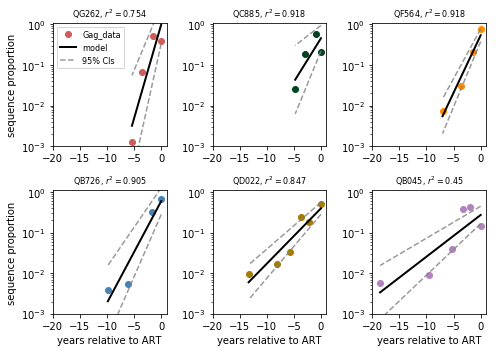

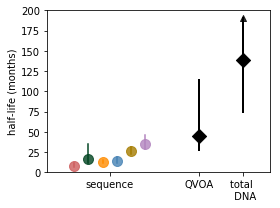

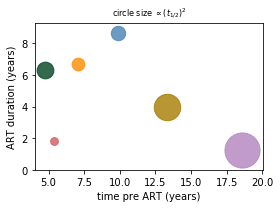

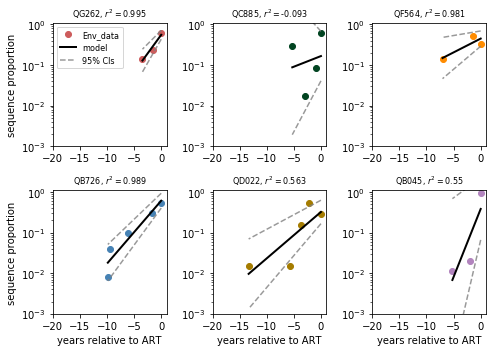

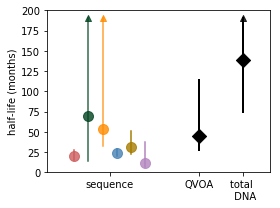

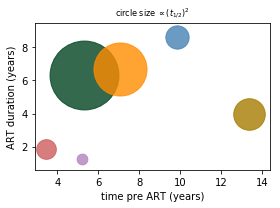

In [13]:
#fit all the halflives

logflg=True #log plot flag
dlflg=False #detection limit flag

for gene in ['Gag','Env']:
    #import data
    df=pd.read_csv('data/053119_Proportions_'+gene+'.csv')
    dfseed=pd.read_csv('data/HIV_DNA_Seeding_Timepoint_'+gene+'.csv') #data frame with phylogenetic proportions
    dfvars=pd.read_csv('data/HIV RNA and DNA Proportions 071519 '+gene+'.csv') #data frame with variant proportions

    ind=0
    hllist=[]
    plt.figure(figsize=(7,5))
    for iid in IDs:
        
        #if detlimit flag, add in the missed time points
        if dlflg:
            tt,Pt=get_props(iid)
            x=tt; y=np.log(Pt)
        else:
            tdf=dfseed[dfseed['ID']==iid]
            t=tdf['Years_Prior_to_ART']
            prop=tdf['Proportion_Each']
            x=t; y=np.log(prop)
        
        popt,pcov=curve_fit(f, x, y, bounds=((0, -10),(10,0)))

        rsq=1-np.sum(np.exp(f(x,popt[0],popt[1]))-np.exp(y))**2/np.sum((np.mean(np.exp(y))-np.exp(y))**2) # 1-model_sq_deviation/data_sq_deviation

        perr = np.sqrt(np.diag(pcov))

        tpre=np.max(x)
        xs=np.linspace(0,tpre,100) #simulation series

        upper=popt+perr*1.96/np.sqrt(len(x))
        lower=popt-perr*1.96/np.sqrt(len(x))

        hl=np.log(2)/popt[0]*12
        hlp=np.log(2)/upper[0]*12
        hlm=np.log(2)/lower[0]*12

        tdfD=df.loc[(df['ID'] == iid) & (df['Nucleic_Acid'] == 'DNA')] #temporary data frame        
        tpost=float(tdfD['YearsSinceART'].iloc[0])

        cz=czpat[ind]
        hllist.append([iid,cz,hl,hlm,hlp,tpre,tpost])
        
        ax=plt.subplot(2,3,ind+1)#axarr[ind]
        ax.plot(-x,np.exp(y),color=cz,marker='o',ls='')
        ax.plot(-xs,np.exp(f(xs,popt[0],popt[1])),color='black',lw=2)
        ax.plot(-xs,np.exp(f(xs,upper[0],lower[1])),color='gray',ls='--',alpha=0.8)
        ax.plot(-xs,np.exp(f(xs,lower[0],upper[1])),color='gray',ls='--',alpha=0.8)

        if logflg:
            ax.semilogy()
        tl=iid+r', $r^2=$' + str(round(rsq,3))
        ax.set_title(tl,fontsize=8)
        ax.set_ylim([1e-3,1.1])
        ax.set_xlim([-20,1])
        ax.set_xticks(range(-20,1,5))
        #ax.set_yticks(np.linspace(0,1,5))
        if ind%3==0:
            ax.set_ylabel('sequence proportion')
        if ind>2:
            ax.set_xlabel('years relative to ART')
        if ind==0:
            ax.legend([gene+'_data','model','95% CIs'],fontsize=8)#,bbox_to_anchor=(1,1.1))
        ind+=1
    plt.tight_layout()
    plt.savefig('figures/'+gene+'_HLfit_log'+str(logflg)+'detlim'+str(dlflg)+'.pdf',dpi=600)

    #compare sequence age half lives vs data
    plt.figure(figsize=(4,3))
    x=np.linspace(0.6,1.4,len(hllist)) #xlocations for half live scatters
    for i in range(len(x)):
        cz=hllist[i][1]
        hl=hllist[i][2]
        hlu=hllist[i][3]
        hll=hllist[i][4]

        if hlu<0:
            hlu=1000
        plt.scatter(x[i],hl,c=cz,alpha=0.8,s=100)
        #truncate error bars with arrow, again handmade
        if hlu>110:
            plt.plot([x[i],x[i]],[hll,190],color=cz,alpha=0.8,ls='-')
            plt.scatter(x[i],190,marker='^',c=cz,alpha=0.8) 
        else:
            plt.plot([x[i],x[i]],[hll,hlu],color=cz,alpha=1,ls='-') #handmade errorbar

    plt.scatter(2,SDat[1],marker='D',s=100,c='k')
    plt.plot([2, 2],[SDat[0], SDat[2]],ls='-',lw=2,color='k')

    plt.scatter(2.5,GDat[1],marker='D',s=100,c='k')
    plt.plot([2.5, 2.5],[GDat[0], 190],ls='-',lw=2,color='k')
    plt.scatter(2.5,190,marker='^',c='k',alpha=0.8)

    plt.tight_layout()
    plt.xticks([1,2,2.5],['sequence','QVOA','total \n DNA'])
    plt.ylabel('half-life (months)')
    plt.xlim([0.3,2.8])
    plt.ylim([0,200])
    plt.tight_layout()
    plt.savefig('figures/'+gene+'_HLcomp'+'detlim'+str(dlflg)+'.pdf',dpi=600)

    #make a dataframe in case want to export
    hl_df=pd.DataFrame(hllist,columns=['ID','color','half-life (months)','upperCI','lowerCI','time pre ART (years)','time post ART (years)'])

    print(gene,'det limit=',dlflg)
    print('mean=',hl_df['half-life (months)'].mean(),' months')
    print('median=',hl_df['half-life (months)'].median(),' months')
    print('range=',hl_df['half-life (months)'].min(),'-',hl_df['half-life (months)'].max(),' months')

    
    #compare sequence half life to time pre ART
    plt.figure(figsize=(4,3))

    for i in range(len(hllist)):
        plt.scatter(hllist[i][5],hllist[i][6],s=hllist[i][2]**2,color=hllist[i][1],alpha=0.8)

    plt.ylabel('ART duration (years)')
    plt.xlabel('time pre ART (years)')
    plt.title(r'circle size $\propto (t_{1/2})^2$',fontsize=8)
    plt.tight_layout()
    plt.savefig('figures/'+gene+'_HLcheck3D'+'detlim'+str(dlflg)+'.pdf',dpi=600)


In [99]:
#put them all together and fit that half life
gene='Gag'

#import data
df=pd.read_csv('data/053119_Proportions_'+gene+'.csv')
dfseed=pd.read_csv('data/HIV_DNA_Seeding_Timepoint_'+gene+'.csv') #data frame with phylogenetic proportions
dfvars=pd.read_csv('data/HIV RNA and DNA Proportions 071519 '+gene+'.csv') #data frame with variant proportions

ttlist=np.arange(np.max(dfseed['Years_Prior_to_ART'])+1)
prlist_tot=np.zeros(int(np.max(dfseed['Years_Prior_to_ART'])+2))
prlist_each=np.zeros([len(IDs),int(np.max(dfseed['Years_Prior_to_ART'])+2)])
i=0
for iid in IDs:
    tdf=dfseed[dfseed['ID']==iid]
    t=tdf['Years_Prior_to_ART']
    prop=tdf['Proportion_Each']
    
    prlist=np.zeros(int(np.max(dfseed['Years_Prior_to_ART'])+2))
    prlist[np.array(np.round(t),dtype=int)]=np.array(prop)
    
    prlist_each[i,:]=prlist
    
    prlist_tot+=prlist
    i+=1


In [100]:
print('median in year 0-1',np.median(prlist_each[:,:1]),'range',min(prlist_each[:,0]),'-',max(prlist_each[:,0]))
print('median in year 0-2',np.median(np.sum(prlist_each[:,:2],1)),'range',min(np.sum(prlist_each[:,:2],1)),'-',max(np.sum(prlist_each[:,:2],1)))


median in year 0-1 0.4602119487175125 range 0.14272076372314998 - 0.7555338252289091
median in year 0-2 0.5933387129204281 range 0.14272076372314998 - 0.9616854831540581


34.56044728597751


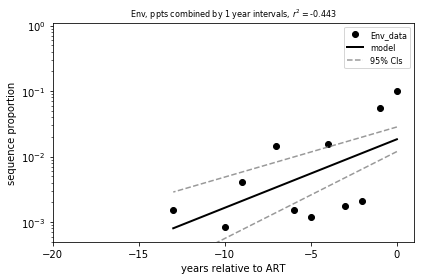

In [90]:
#now fit and plot all together

x=ttlist[prlist>0]; y=np.log(prlist[prlist_tot>0]/np.sum(prlist_tot))
        
popt,pcov=curve_fit(f, x, y, bounds=((0, -10),(10,0)))
        
hl=np.log(2)/popt[0]*12
print(hl)

rsq=1-np.sum(np.exp(f(x,popt[0],popt[1]))-np.exp(y))**2/np.sum((np.mean(np.exp(y))-np.exp(y))**2) # 1-model_sq_deviation/data_sq_deviation

tpre=np.max(x)
xs=np.linspace(0,tpre,100) #simulation series

perr = np.sqrt(np.diag(pcov))

upper=popt+perr*1.96/np.sqrt(len(x))
lower=popt-perr*1.96/np.sqrt(len(x))

ax=plt.subplot(111)#axarr[ind]
ax.plot(-x,np.exp(y),color='k',marker='o',ls='')
ax.plot(-xs,np.exp(f(xs,popt[0],popt[1])),color='black',lw=2)
ax.plot(-xs,np.exp(f(xs,upper[0],lower[1])),color='gray',ls='--',alpha=0.8)
ax.plot(-xs,np.exp(f(xs,lower[0],upper[1])),color='gray',ls='--',alpha=0.8)

if logflg:
    ax.semilogy()
tl=gene+', ppts combined by 1 year intervals'+r', $r^2=$' + str(round(rsq,3))
ax.set_title(tl,fontsize=8)
ax.set_ylim([5e-4,1.1])
ax.set_xlim([-20,1])
ax.set_xticks(range(-20,1,5))
ax.set_ylabel('sequence proportion')
ax.set_xlabel('years relative to ART')
ax.legend([gene+'_data','model','95% CIs'],fontsize=8)#,bbox_to_anchor=(1,1.1))
plt.tight_layout()
plt.savefig('figures/'+gene+'_HLfitall.pdf',dpi=600)
